# ANÁLISIS DE LOS RESULTADOS

***
<code> **PROYECTO NOVELLA** </code>

En este *notebook* se pretende evaluar el rendimiento de nuestro modelo final (MLP) con los nuevos datos obtenidos. Asimismo, implementaremos un modelo que se base en una heurística concreta y compararemos tanto a nivel global como por segmentos los resultados con los de nuestro modelo final. Por último, realizaremos un estudio de las métricas solo para cuando el autor del libro no tiene bestsellers previos.

**Índice**
***

[1. Carga y preparación datos train y test](#1.-Carga-y-preparación-de-los-datos)

[2. Transformaciones y SMOTE-NC](#2.-Transformaciones-y-SMOTE-NC)

[3. Recuperación del modelo final](#3.-Recuperación-del-modelo-final)

[4. Definición de la heurística](#4.-Definición-de-la-heurística)

**5. Análisis**
* [5.1 Análisis comparativo de las métricas principales](#5.1-Análisis-comparativo-de-las-métricas-principales)
* [5.2 Análisis por segmentos (géneros literarios principales)](#5.2-Análisis-por-segmentos-(géneros-literarios-principales))
* [5.3 Análisis de rendimiento en libros cuyo autor no tiene bestsellers previos](#5.3-Análisis-de-rendimiento-en-libros-cuyo-autor-no-tiene-bestsellers-previos)
***

## 1. Carga y preparación de los datos

**Carga de los datos**

In [1]:
import pandas as pd

In [2]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive')
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

In [3]:
# -- IMPORTAMOS FUNCIONES COMUNES --

from pathlib import Path

# Obtenemos la ruta al directorio del módulo utilidadesModelos.py
module_dir = Path("../modelos") 

# Agregamos temporalmente el directorio al sys.path solo para esta importación
sys.path.append(str(module_dir))

from utilidadesModelos import *

En primer lugar, vamos a cargar los datos con los que realizamos la fase de entrenamiento y elegimos nuestro modelo candidato,

In [4]:
# Descargamos los datos en formato parquet de Google Drive
drive.descargar_archivos_concretos('datosEntrenamiento.parquet', '../drive')
drive.descargar_archivos_concretos('test_FINAL_IMPUTADOS.parquet', '../drive')

Archivo datosEntrenamiento.parquet guardado en: ../data/clean/datosEntrenamiento.parquet
Archivo test_FINAL_IMPUTADOS.parquet guardado en: ./data/clean/test_FINAL_IMPUTADOS.parquet


In [5]:
data = pd.read_parquet('../data/clean/datosEntrenamiento.parquet')

In [6]:
data

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,...,Womens,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
0,0.0,329.0,1.0,0.51,0.40,0,19.99,1.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,269.0,2.0,0.61,0.54,1,3.99,2.0,ebook,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2335.0,1.0,0.72,0.57,1,20.99,7.0,ebook,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,40.0,1.0,0.83,0.35,0,25.00,1.0,hardcover,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,189.0,1.0,0.59,0.26,0,15.00,4.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,0.0,432.0,1.0,0.40,0.38,1,25.35,5.0,hardcover,100.0,...,0,0,0,0,0,0,0,0,0,0
3686,0.0,304.0,1.0,0.27,0.28,0,18.99,3.0,paperback,103.0,...,0,0,0,0,0,0,0,0,0,0
3687,0.0,160.0,1.0,0.10,0.16,0,15.39,5.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
3688,0.0,304.0,1.0,0.51,0.43,0,25.19,3.0,hardcover,590.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
newData = pd.read_parquet('data/clean/test_FINAL_IMPUTADOS.parquet')

In [8]:
newData

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,BookInterest1M,Rating20Days,...,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies,PriceFormat
0,0.0,548.0,1.0,0.32,0.27,1,24.30,2.0,436.0,4.15,...,0,0,0,1,0,0,0,0,0,ebook
1,0.0,304.0,1.0,0.80,0.29,0,10.99,3.0,97.0,4.16,...,0,0,0,1,0,0,0,0,0,hardcover
2,0.0,352.0,1.0,0.39,0.35,0,18.00,3.0,64.0,3.45,...,0,0,0,0,0,0,0,0,0,paperback
3,0.0,336.0,1.0,0.13,0.13,1,17.99,2.0,211.0,4.10,...,0,0,0,1,0,1,0,0,0,paperback
4,0.0,232.0,1.0,0.87,0.20,1,13.99,2.0,67.0,3.50,...,0,0,0,0,0,0,0,0,0,hardcover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.0,382.0,1.0,0.77,0.57,0,15.08,7.0,133.0,4.02,...,0,0,0,1,0,0,0,0,0,ebook
323,0.0,384.0,1.0,0.80,0.39,0,25.20,3.0,33.0,3.78,...,0,0,0,0,0,0,0,0,0,hardcover
324,0.0,464.0,5.0,0.09,0.25,1,13.49,2.0,270.0,3.87,...,0,0,0,1,0,0,0,0,0,paperback
325,0.0,368.0,1.0,0.58,0.49,1,27.00,5.0,100.0,3.46,...,0,0,0,1,0,1,0,0,0,hardcover


**Separación de los datos**

Separamos el conjunto de datos de entrenamiento sin escalar en train y test

In [9]:
y, X = getYX(data)
X_train, X_test, y_train, y_test = separacionTrainTest(X, y)

In [10]:
X_test.head()

,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,Rating20Days,...,Womens,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
2588,322.0,1.0,0.49,0.43,0,16.99,4.0,paperback,100.0,4.48,...,0,0,0,0,0,0,0,0,0,0
746,270.0,1.0,0.17,0.44,1,16.99,3.0,paperback,100.0,4.10,...,0,0,0,0,0,0,0,0,0,0
3055,608.0,1.0,0.28,0.42,0,29.99,2.0,hardcover,100.0,3.95,...,0,0,0,0,0,0,0,0,0,0
426,333.0,2.0,0.11,0.22,1,20.30,1.0,hardcover,1497.0,4.63,...,0,0,0,0,0,0,0,0,0,0
1877,384.0,1.0,0.29,0.13,0,16.79,5.0,paperback,186.0,4.28,...,0,0,0,0,0,0,0,0,0,0


Separamos los nuevos datos capturados en X e y

In [11]:
yN, XN = getYX(newData)

## 2. Transformaciones y SMOTE-NC

### Escalado de variables
A continuación, vamos a realizar un escalado robusto de las variables numéricas.

In [12]:
from sklearn.preprocessing import RobustScaler

Lo aplicamos primero solo al conjunto de entrenamiento de los datos al igual que en la entrega anterior.

In [13]:
data_scaled = data.copy()
X_scaled = data_scaled.drop('Bestseller', axis=1)
y_scaled = data_scaled['Bestseller']

# Dividimos en train y test
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled, y_scaled, test_size=TEST_SIZE, stratify=y, random_state=SEED)

# Inicializamos RobustScaler
scaler = RobustScaler()

# Solo lo aplicamos a las variables numéricas
variables_numericas = ['SagaNumber', 'NumPages', 'RedPerc', 'BluePerc', 'Price', 'WordsTitle', 'BookInterest1M',
                     'Rating20Days', 'PrevBestSellAuthor']

# Aplicamos el RobustScaler a los datos de entrenamiento y test
X_scaled_train[variables_numericas] = scaler.fit_transform(X_scaled_train[variables_numericas])
X_scaled_test[variables_numericas] = scaler.transform(X_scaled_test[variables_numericas])

In [14]:
X_scaled_test.head()

,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,Rating20Days,...,Womens,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
2588,-0.291667,0.0,0.081081,0.078740,0,-0.064856,0.5,paperback,0.000000,0.666667,...,0,0,0,0,0,0,0,0,0,0
746,-0.833333,0.0,-0.783784,0.110236,1,-0.064856,0.0,paperback,0.000000,-0.078431,...,0,0,0,0,0,0,0,0,0,0
3055,2.687500,0.0,-0.486486,0.047244,0,2.042967,-0.5,hardcover,0.000000,-0.372549,...,0,0,0,0,0,0,0,0,0,0
426,-0.177083,1.0,-0.945946,-0.582677,1,0.471828,-1.0,hardcover,7.937500,0.960784,...,0,0,0,0,0,0,0,0,0,0
1877,0.354167,0.0,-0.459459,-0.866142,0,-0.097284,1.0,paperback,0.488636,0.274510,...,0,0,0,0,0,0,0,0,0,0


Por otro lado, también vamos a aplicárselo a los datos frescos. Para ello, tomaremos como conjunto de entrenamiento la **totalidad de los datos de la fase de entrenamiento**, y con ellos entrenaremos el RobustScaler.

In [15]:
dataN_scaled = newData.copy()

XN_scaled_train = data_scaled.drop('Bestseller', axis=1)
yN_scaled_train = data_scaled['Bestseller']
XN_scaled_test = dataN_scaled.drop('Bestseller', axis=1)
yN_scaled_test = dataN_scaled['Bestseller']

# Inicializamos RobustScaler
scaler = RobustScaler()

# Solo lo aplicamos a las variables numéricas
variables_numericas = ['SagaNumber', 'NumPages', 'RedPerc', 'BluePerc', 'Price', 'WordsTitle', 'BookInterest1M',
                     'Rating20Days', 'PrevBestSellAuthor']

# Aplicamos el RobustScaler a los datos de entrenamiento y test
XN_scaled_train[variables_numericas] = scaler.fit_transform(XN_scaled_train[variables_numericas])
XN_scaled_test[variables_numericas] = scaler.transform(XN_scaled_test[variables_numericas])

In [16]:
XN_scaled_test

,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,BookInterest1M,Rating20Days,HasTwitter,...,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies,PriceFormat
0,2.052083,0.0,-0.368421,-0.40625,1,1.110486,-0.5,1.909091,0.02,0.0,...,0,0,0,1,0,0,0,0,0,ebook
1,-0.489583,0.0,0.894737,-0.34375,0,-1.028526,0.0,-0.017045,0.04,0.0,...,0,0,0,1,0,0,0,0,0,hardcover
2,0.010417,0.0,-0.184211,-0.15625,0,0.098031,0.0,-0.204545,-1.38,1.0,...,0,0,0,0,0,0,0,0,0,paperback
3,-0.156250,0.0,-0.868421,-0.84375,1,0.096424,-0.5,0.630682,-0.08,0.0,...,0,0,0,1,0,1,0,0,0,paperback
4,-1.239583,0.0,1.078947,-0.62500,1,-0.546404,-0.5,-0.187500,-1.28,0.0,...,0,0,0,0,0,0,0,0,0,hardcover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.322917,0.0,0.815789,0.53125,0,-0.371233,2.0,0.187500,-0.24,0.0,...,0,0,0,1,0,0,0,0,0,ebook
323,0.343750,0.0,0.894737,-0.03125,0,1.255123,0.0,-0.380682,-0.72,0.0,...,0,0,0,0,0,0,0,0,0,hardcover
324,1.177083,4.0,-0.973684,-0.46875,1,-0.626758,-0.5,0.965909,-0.54,0.0,...,0,0,0,1,0,0,0,0,0,paperback
325,0.177083,0.0,0.315789,0.28125,1,1.544395,1.0,0.000000,-1.36,0.0,...,0,0,0,1,0,1,0,0,0,hardcover


### SMOTE-NC y One-Hot Encoding

Como nuestra variable respuesta está desbalanceada, tenemos que:
1. Aplicar SMOTE-NC a los datos de entrenamiento para conseguir una proporción 50/50 y  un buen rendimiento del modelo. 
2. Redondear las variables que deben ser enteras pero se han convertido en decimales tras esta transformación
3. Aplicar OHE a PriceFormat (se hace después para que una fila no tenga múltiples valores de PriceFormat por el SMOTENC)

In [17]:
from imblearn.over_sampling import SMOTENC
import numpy as np

In [18]:
# Columnas de los géneros
columnasGeneros = X_scaled_train.columns[12:]

# Columnas categóricas
categoricalColumns = ["BelongsSaga", "PriceFormat", 'HasTwitter', 'HasWikipedia'] + list(columnasGeneros)

# Definimos la transformación smote
smote = SMOTENC(categorical_features = categoricalColumns, random_state = SEED)

In [19]:
def transformarTrain(X, y):
    """Aplica smote-nc, redondea las columnas y codifica priceFormat"""
    X_t, y_t = smote.fit_resample(X, y)
    X_t = redondearVariables(X_t)
    X_t = codificarPriceFormat(X_t)
    return X_t, y_t

Aplicamos las transformaciones a los datos de train

In [20]:
X_scaled_train, y_scaled_train = transformarTrain(X_scaled_train, y_scaled_train)
XN_scaled_train, yN_scaled_train = transformarTrain(XN_scaled_train, yN_scaled_train)

### Transformación de los datos de test

Aplicamos OHE a PriceFormat para transformar los datos de test.

In [21]:
X_scaled_test = codificarPriceFormat(X_scaled_test)
XN_scaled_test = codificarPriceFormat(XN_scaled_test)

## 3. Recuperación del modelo final

A continuación vamos a recuperar el modelo que decidimos que pasase a la fase de producción en la entrega anterior: el MLP.

En primer lugar descargamos la base de datos de los experimentos de Google Drive

In [22]:
# Nombres de los archivos de las bases de datos en archivos_info.txt
NOMBRES_DBS = ['MLP_runs.db']

In [23]:
drive.descargar_archivos_concretos(NOMBRES_DBS, '../drive')

Archivo MLP_runs.db guardado en: ./databases/MLP_runs.db


In [24]:
import mlflow.pyfunc
import sqlite3

* Cargamos los parámetros de cada modelo candidato con mlflow
* Creamos el modelo correspondiente con esos parametros
* Entrenamos el modelo con los datos correspondientes (tras aplicar las transformaciones necesarias a los datos en cada caso)

In [25]:
# Función para cargar los hiperparámetros de un modelo
def load_model_from_db(database_name, run_id):
    """Dada una base de datos de SQLite y un Run ID devuelve los parámetros del modelo"""

    # Ruta completa de la base de datos en la carpeta "databases"
    db_path = os.path.join('databases', database_name)

    # Configuramos la URI del seguimiento de MLflow para que apunte a la base de datos SQLite
    mlflow.set_tracking_uri(f"sqlite:///{db_path}")

    # Conectamos con la base de datos SQLite
    conn = sqlite3.connect(db_path)
    
    # Obtenemos los hiperparámetros del modelo
    query = f"SELECT * FROM params WHERE run_uuid = '{run_id}'"
    params = conn.execute(query).fetchall()
    model_params = {param[0]: param[1] for param in params}

    return model_params

In [26]:
def clean_params(params):
    cleaned_params = {}
    for key, value in params.items():
        # Remove the 'classifier__' prefix from the key
        cleaned_key = key.replace('classifier__', '')
        
        # Convert specific string values to appropriate types
        if value.lower() == 'true':
            cleaned_params[cleaned_key] = True
        elif value.lower() == 'false':
            cleaned_params[cleaned_key] = False
        else:
            # Check if the value is in the form of a tuple
            if value.startswith('(') and value.endswith(')'):
                try:
                    # Convert the string representation of tuple to a tuple
                    tuple_value = tuple(map(int, value.strip('()').split(',')))
                    cleaned_params[cleaned_key] = tuple_value
                except ValueError:
                    cleaned_params[cleaned_key] = value
            else:
                # Try converting the value to a float
                try:
                    float_value = float(value)
                    # Convert to int if the float value has no decimals
                    if float_value.is_integer():
                        cleaned_params[cleaned_key] = int(float_value)
                    else:
                        cleaned_params[cleaned_key] = float_value
                # If conversion fails, keep the original value
                except ValueError:
                    cleaned_params[cleaned_key] = value
    return cleaned_params

Los parámetros elegidos del modelo que no aparecen en la tarjeta es porque coinciden con los parámetros por defecto.

**Perceptrón multicapa (MLP)**

In [27]:
from sklearn.neural_network import MLPClassifier

In [28]:
# Definimos la base de datos
mlp_database_name = 'MLP_runs.db'
mlp_run_id = '8c2da395658847e2b4c7ba6114ef8d60'

# Cargamos los parámetros
mlp_params = load_model_from_db(mlp_database_name, mlp_run_id)

# Creamos el modelo
MLP_model = MLPClassifier(**clean_params(mlp_params), random_state = SEED)
MLP_model_reentreno = MLPClassifier(**clean_params(mlp_params), random_state = SEED)

# Entrenamos el modelo
MLP_model.fit(X_scaled_train, y_scaled_train)
MLP_model_reentreno.fit(XN_scaled_train, yN_scaled_train)

/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  

/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  

MLPClassifier(activation='logistic', alpha=0.8773407884629941,
              early_stopping=True, hidden_layer_sizes=(150, 150),
              learning_rate='adaptive',
              learning_rate_init=0.0023019050769459534, random_state=22)

In [29]:
MLP_model

MLPClassifier(activation='logistic', alpha=0.8773407884629941,
              early_stopping=True, hidden_layer_sizes=(150, 150),
              learning_rate='adaptive',
              learning_rate_init=0.0023019050769459534, random_state=22)

## 4. Definición de la heurística

La heurística con la que vamos a trabajar es «un libro será bestseller si algún libro previo del autor fue bestseller»

In [30]:
def prediccionesHeuristica(X):
    """Devuelve las predicciones de si un libro va a ser bestseller o no en función de la heurística
    'un libro será bestseller si algún libro previo del autor fue bestseller'
    """
    predicciones = [1 if fila["PrevBestSellAuthor"] > 0 else 0 for _, fila in X.iterrows()]
    return predicciones

## 5. Análisis

In [31]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### 5.1 Análisis comparativo de las métricas principales

Calculamos las predicciones de cada modelo con los datos de test correspondientes

In [32]:
# Generamos las predicciones
MLP_pred = MLP_model.predict(X_scaled_test)
MLP_pred_reentreno = MLP_model_reentreno.predict(XN_scaled_test)
HEURISTICA_pred_antiguas = prediccionesHeuristica(X_scaled_test)
HEURISTICA_pred_nuevas = prediccionesHeuristica(XN_scaled_test)

# Lista de modelos
models = ['MLP ANTIGUOS', 'MLP NUEVOS', 'HEURISTICA ANTIGUOS', 'HEURISTICA NUEVOS']

# Lista de predicciones de cada modelo
predictions = [MLP_pred, MLP_pred_reentreno, HEURISTICA_pred_antiguas, HEURISTICA_pred_nuevas]

# Almacenamos los valores reales de la variable respuesta
ys = [y_test, yN, y_test, yN]

Calculamos las tasas de aciertos balanceadas.

In [33]:
# Lista para almacenar los resultados
balanced_accuracy_results = []

# Calcular balanced accuracy para cada modelo
for model, prediction, y in zip(models, predictions, ys):
    
    balanced_acc = balanced_accuracy_score(y, prediction)
    balanced_accuracy_results.append((model, balanced_acc))

# Crear un DataFrame con los resultados
df_bal_acc = pd.DataFrame(balanced_accuracy_results, columns=['Model', 'Balanced Accuracy'])
df_bal_acc

,Model,Balanced Accuracy
0,MLP ANTIGUOS,0.783460
1,MLP NUEVOS,0.715303
2,HEURISTICA ANTIGUOS,0.631070
3,HEURISTICA NUEVOS,0.733516


In [34]:
def plot_confusion_matrix(cm, model_name):
    """
    Plots the confusion matrix using seaborn's heatmap.
    
    Parameters:
        cm (array): Confusion matrix.
        model_name (str): Name of the model.
    """
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

Calculamos sensibilidad y especificidad

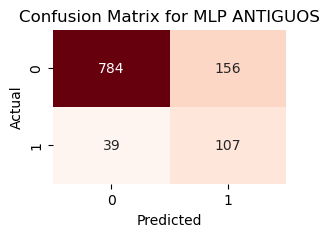

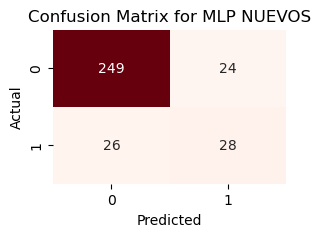

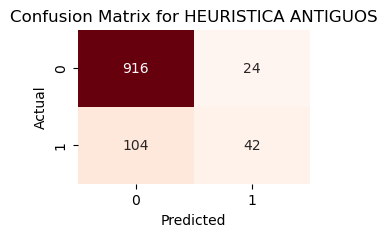

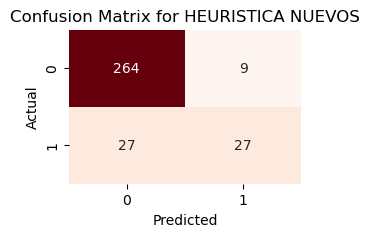

In [35]:
specificity_results = []
sensitivity_results = []

# Calcular especificidad y sensibilidad para cada modelo
for model, prediction, y in zip(models, predictions, ys):
    # Calcular la matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y, prediction).ravel()
    
    # Print confusion matrix
    cm = confusion_matrix(y, prediction)
    plot_confusion_matrix(cm, model)
    
    # Calcular especificidad y sensibilidad
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    # Agregar los resultados a las listas
    specificity_results.append(specificity)
    sensitivity_results.append(sensitivity)

# Crear un DataFrame con los resultados de especificidad
df_specificity = pd.DataFrame({'Model': models, 'Specificity': specificity_results})

# Crear un DataFrame con los resultados de sensibilidad
df_sensitivity = pd.DataFrame({'Model': models, 'Sensitivity': sensitivity_results})

Mostramos el rendimiento de los distintos modelos

In [36]:
df_results = pd.merge(df_bal_acc, df_specificity)
df_results = pd.merge(df_results, df_sensitivity)
df_results

,Model,Balanced Accuracy,Specificity,Sensitivity
0,MLP ANTIGUOS,0.783460,0.834043,0.732877
1,MLP NUEVOS,0.715303,0.912088,0.518519
2,HEURISTICA ANTIGUOS,0.631070,0.974468,0.287671
3,HEURISTICA NUEVOS,0.733516,0.967033,0.500000


### 5.2 Análisis por segmentos (géneros literarios principales)

In [37]:
# Definimos los mismos segmentos que en la entrega anterior
segmentos = ["Contemporary", "Romance", "Adult", "Mystery", "Thriller", "Resto"]

In [38]:
# Función para calcular la sensibilidad
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

# Función para calcular la especificidad
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

In [39]:
import numpy as np

def evaluacionSegmentadaModelos(models, X_t, y_t, predictions):
    """Devuelve la balanced accuracy, especificidad y sensibilidad de los modelos dados por segmentos"""
    
    results = []

    # Recorremos los segmentos
    for s in segmentos:
        
        # Filtramos el df
        if s == "Resto":
            filtro = ~(X_t[segmentos[:-1]] == 1).any(axis=1)
            X_test_segmentado = X_t[filtro]
        else:
            filtro = X_t[s] == 1
            X_test_segmentado = X_t[X_t[s] == 1]
        
        ys = y_t[X_test_segmentado.index]
        
        # Recorremos los modelos
        for i, model in enumerate(models):
        
            # Obtenemos las predicciones
            predictionsModel = predictions[i]
            preds = [predictionsModel[i] for i, x in enumerate(filtro) if x == 1]
    
            # Calculamos las métricas
            sen = sensitivity(ys, preds)
            esp = specificity(ys, preds)
            ba = balanced_accuracy_score(ys, preds)

            # Añadimos los resultados a la lista
            results.append({
                'Segmento': s,
                'Modelo': model,
                'Sensibilidad': sen,
                'Especificidad': esp,
                'Precisión balanceada': ba
            })
    
    # Generamos el df
    df_results = pd.DataFrame(results)
    return df_results

# DF con la evaluación por segmentos de los modelos con los datos de la entrega anterior
df_evSegAntiguos = evaluacionSegmentadaModelos(["MLP (Datos antiguos)", "HEURÍSTICA (Datos antiguos)"], 
                                               X_scaled_test, y_test, [MLP_pred, HEURISTICA_pred_antiguas])

# DF con la evaluación por segmentos de los modelos con los datos nuevos
df_evSegNuevos = evaluacionSegmentadaModelos(["MLP (Datos nuevos)", "HEURÍSTICA (Datos nuevos)"], 
                                               XN_scaled_test, yN, [MLP_pred_reentreno, HEURISTICA_pred_nuevas])

In [40]:

def plot_results(df_results, colors):
    """Muestra diagramas de barras con los que comparar las métricas de los modelos"""
    
    # Agrupamos los datos por segmento y modelo
    grouped_results = df_results.groupby(['Segmento', 'Modelo'])

    # Obtenemos las métricas para cada segmento y modelo
    sensitivities = grouped_results['Sensibilidad'].mean().unstack()
    specificities = grouped_results['Especificidad'].mean().unstack()
    balanced_accuracies = grouped_results['Precisión balanceada'].mean().unstack()

    # Creamos un gráfico de barras para cada métrica
    segments = df_results['Segmento'].unique()
    models = df_results['Modelo'].unique()
    num_models = len(models)
    bar_width = 0.25
    index = np.arange(len(segments))

    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Sensibilidad
    for i, model in enumerate(models):
        axs[0].bar(index + i * bar_width, sensitivities[model], bar_width, label=model, color=colors[i])

    axs[0].set_xlabel('Segmento')
    axs[0].set_ylabel('Sensibilidad')
    axs[0].set_title('Sensibilidad por Segmento y Modelo')
    axs[0].set_xticks(index + bar_width * (num_models - 1) / 2)
    axs[0].set_xticklabels(segments)
    axs[0].set_ylim(0, 1)
    axs[0].legend()

    # Especificidad
    for i, model in enumerate(models):
        axs[1].bar(index + i * bar_width, specificities[model], bar_width, label=model, color=colors[i])

    axs[1].set_xlabel('Segmento')
    axs[1].set_ylabel('Especificidad')
    axs[1].set_title('Especificidad por segmento y modelo')
    axs[1].set_xticks(index + bar_width * (num_models - 1) / 2)
    axs[1].set_xticklabels(segments)
    axs[1].set_ylim(0, 1)
    axs[1].legend()

    # Precisión balanceada
    for i, model in enumerate(models):
        axs[2].bar(index + i * bar_width, balanced_accuracies[model], bar_width, label=model, color=colors[i])

    axs[2].set_xlabel('Segmento')
    axs[2].set_ylabel('Precisión balanceada')
    axs[2].set_title('Balanced accuracy por segmento y modelo')
    axs[2].set_xticks(index + bar_width * (num_models - 1) / 2)
    axs[2].set_xticklabels(segments)
    axs[2].set_ylim(0, 1)
    axs[2].legend()

    plt.tight_layout()
    plt.show()

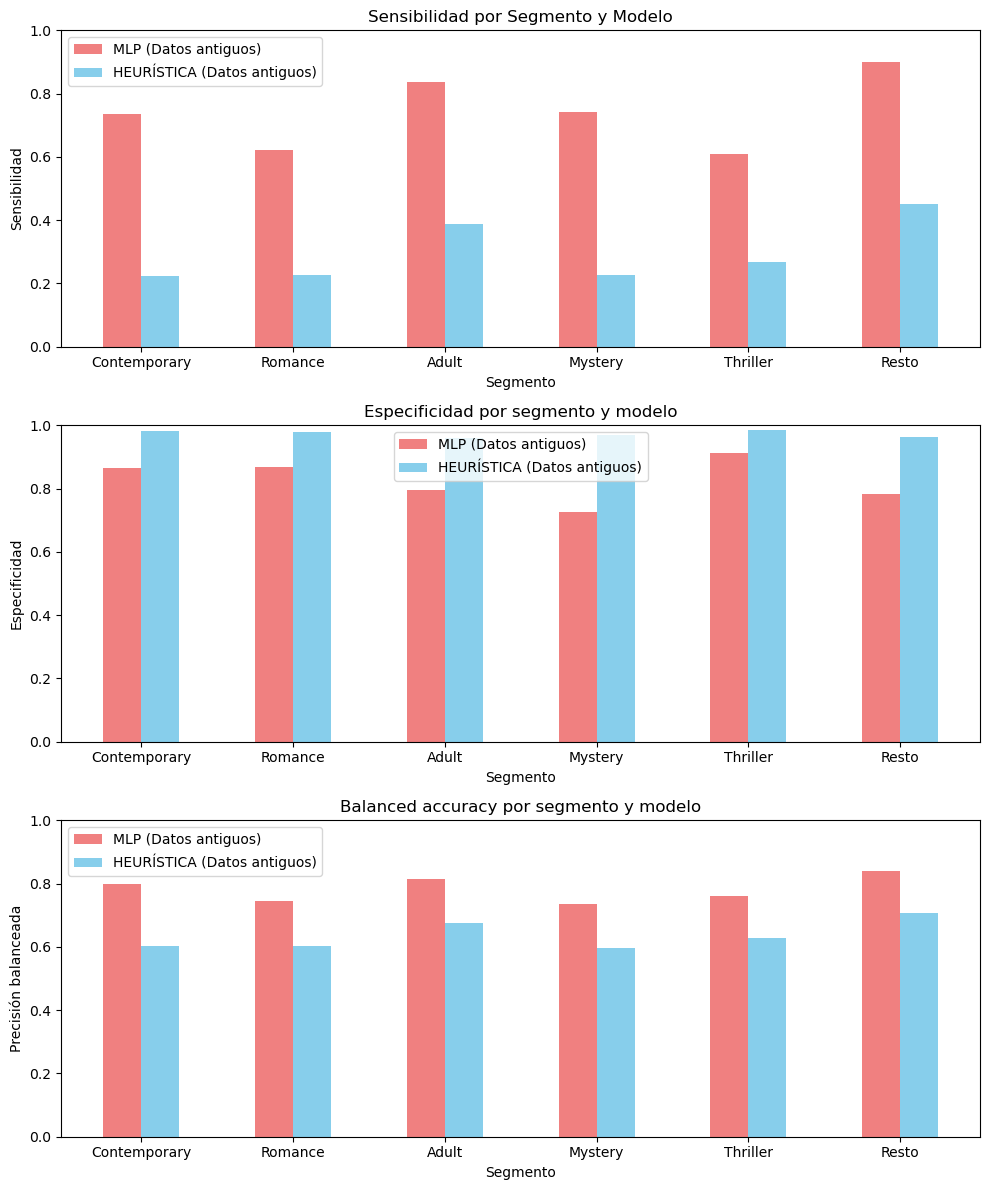

In [41]:
# Mostramos las gráficas del rendimiento de los modelos por segmentos con los datos antiguos
plot_results(df_evSegAntiguos, ['lightcoral', 'skyblue'])

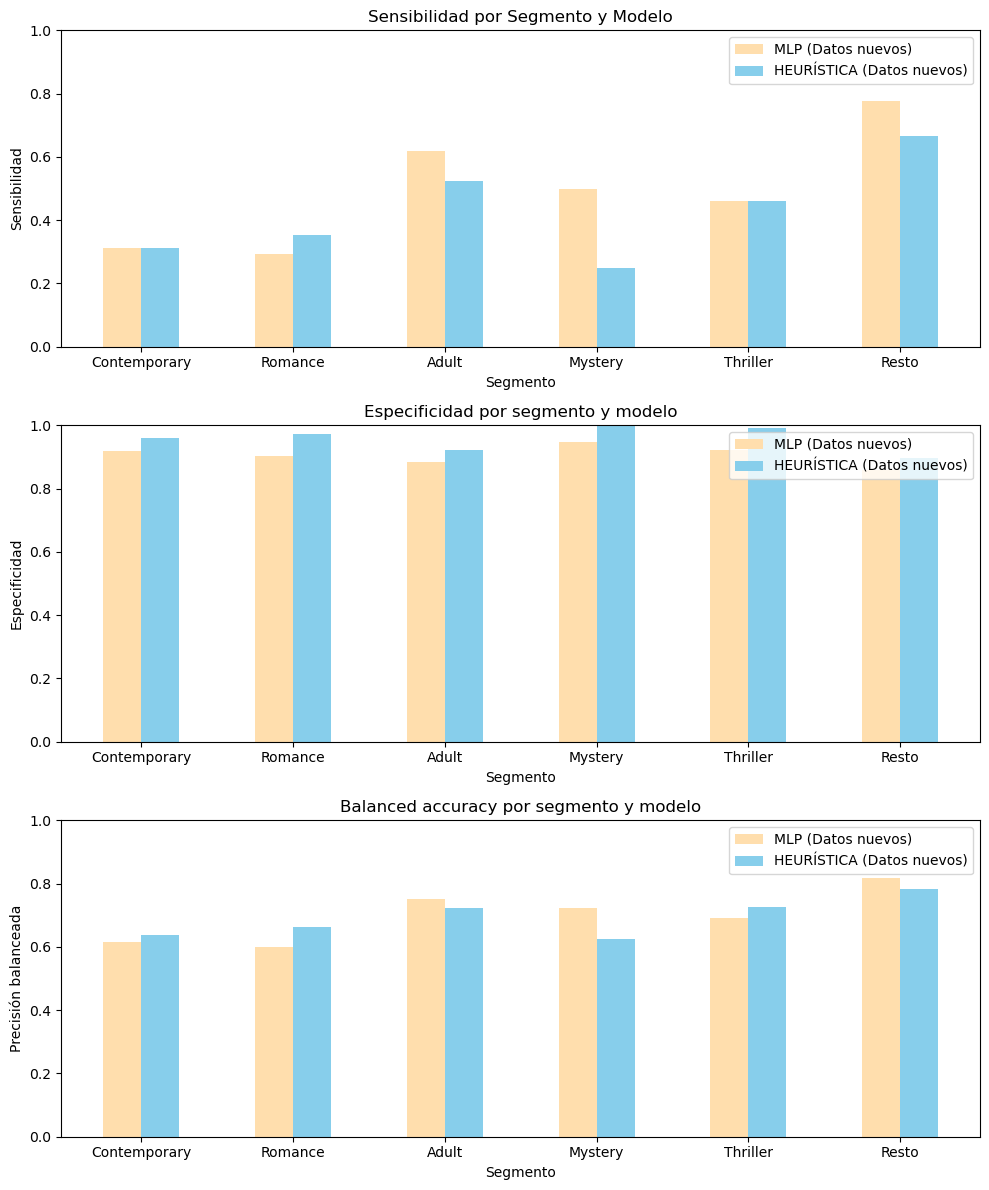

In [42]:
# Mostramos las gráficas del rendimiento de los modelos por segmentos con los datos nuevos
plot_results(df_evSegNuevos, ['navajowhite', 'skyblue'])

### 5.3 Análisis de rendimiento en libros cuyo autor no tiene bestsellers previos

In [43]:
# Creamos un filtro con aquellos libros que no sean bestsellers
filtroNoBestsellers_antiguos = X_scaled_test["PrevBestSellAuthor"] == 0
filtroNoBestsellers_nuevos = XN_scaled_test["PrevBestSellAuthor"] == 0

# Aplicamos el filtro
X_nobest= X_scaled_test[filtroNoBestsellers_antiguos]
XN_nobest = XN_scaled_test[filtroNoBestsellers_nuevos]

# Seleccionar las filas correspondientes en y_TEST
y_nobest = y_test[filtroNoBestsellers_antiguos]
yN_nobest = yN[filtroNoBestsellers_nuevos]

In [44]:
# Generamos las predicciones
MLP_pred_nb = MLP_model.predict(X_nobest)
MLP_pred_reentreno_nb = MLP_model_reentreno.predict(XN_nobest)
HEURISTICA_pred_antiguas_nb = prediccionesHeuristica(X_nobest)
HEURISTICA_pred_nuevas_nb = prediccionesHeuristica(XN_nobest)

In [45]:
def calcular_sensibilidad_especificidad(y_true, y_pred):
    """Calcula la sensibilidad y especificidad"""

    sensibilidad = sensitivity(y_true, y_pred)
    especificidad = specificity(y_true, y_pred)
    
    return sensibilidad, especificidad

# Calculamos la sensibilidad y especificidad para los modelos
sensibilidad_MLP_nb, especificidad_MLP_nb = calcular_sensibilidad_especificidad(y_nobest, MLP_pred_nb)
sensibilidad_MLP_reentreno_nb, especificidad_MLP_reentreno_nb = calcular_sensibilidad_especificidad(yN_nobest, MLP_pred_reentreno_nb)
sensibilidad_HEURISTICA_antiguas_nb, especificidad_HEURISTICA_antiguas_nb = calcular_sensibilidad_especificidad(y_nobest, HEURISTICA_pred_antiguas_nb)
sensibilidad_HEURISTICA_nuevas_nb, especificidad_HEURISTICA_nuevas_nb = calcular_sensibilidad_especificidad(yN_nobest, HEURISTICA_pred_nuevas_nb)

# Calculamos la balanced accuracy score para los modelos
balanced_accuracy_MLP_nb = balanced_accuracy_score(y_nobest, MLP_pred_nb)
balanced_accuracy_MLP_reentreno_nb = balanced_accuracy_score(yN_nobest, MLP_pred_reentreno_nb)
balanced_accuracy_HEURISTICA_antiguas_nb = balanced_accuracy_score(y_nobest, HEURISTICA_pred_antiguas_nb)
balanced_accuracy_HEURISTICA_nuevas_nb = balanced_accuracy_score(yN_nobest, HEURISTICA_pred_nuevas_nb)

# Generamos el df
data = {
    'Modelo': ['MLP', 'MLP con reentrenamiento', 'Heurística (antiguas)', 'Heurística (nuevas)'],
    'Sensibilidad': [sensibilidad_MLP_nb, sensibilidad_MLP_reentreno_nb, sensibilidad_HEURISTICA_antiguas_nb, sensibilidad_HEURISTICA_nuevas_nb],
    'Especificidad': [especificidad_MLP_nb, especificidad_MLP_reentreno_nb, especificidad_HEURISTICA_antiguas_nb, especificidad_HEURISTICA_nuevas_nb],
    'Balanced Accuracy': [balanced_accuracy_MLP_nb, balanced_accuracy_MLP_reentreno_nb, balanced_accuracy_HEURISTICA_antiguas_nb, balanced_accuracy_HEURISTICA_nuevas_nb]
}

df_resultados = pd.DataFrame(data)

# Mostrar el DataFrame
df_resultados


,Modelo,Sensibilidad,Especificidad,Balanced Accuracy
0,MLP,0.653846,0.844978,0.749412
1,MLP con reentrenamiento,0.222222,0.920455,0.571338
2,Heurística (antiguas),0.000000,1.000000,0.500000
3,Heurística (nuevas),0.000000,1.000000,0.500000
